**Mapping closure for $f_B$ in 1D using a Monte-Carlo Implementation**

This notebook introduces the mapping closure developed by (Chen, H. 1989, Pope, S.B. 1991) and discusses how it can be applied to the problem of turbulent scalar mixing. In contrast to these works which consider a one-point pdf, usually in the context of homogeneous isotropic turbulence, we consider the *global pdf* describing the contents of an arbitrary control volume.


**Content**

We first import all the packages we need to run this example

In [50]:
import numpy as np
import matplotlib.pyplot as plt

**Evolution equation for the PDF**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by

\begin{equation}
\frac{\partial F}{\partial t} = -\mathbb{E}_Y[ \Gamma \nabla^2 Y ] \frac{\partial F}{\partial y},
\end{equation}

and

\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial y} \left( \mathbb{E}_Y[ \Gamma \nabla^2 Y ] f \right).
\end{equation}

As $f(y,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the mapping closure developed by [Pope et al. 1991](https://link.springer.com/article/10.1007/BF00271466) to estimate a closure for the molecular mixing terms.

The idea behind this closure relies on Gaussian random fields. What makes these "random" fields particularly useful is:
- They are completely defined by their mean and covariance: 
\begin{equation}
    \mu = \mathbb{E}[\theta(\mathbf{z})], \quad \rho(r) = \mathbb{E}[\theta(\mathbf{z})\theta(\mathbf{z} + \mathbf{e}r)] - \mu^2,
\end{equation}
- Allow the calculate explicity the conditional expectation
\begin{equation}
lim_{r \to 0} \frac{\partial^2 \rho(r)}{\partial r^2} = \left\langle \frac{\partial \theta}{\partial z_i} \frac{\partial \theta}{\partial z_i} \right\rangle,
\end{equation}

and the fact that multiple different field can have the same global PDF.


**Mapping Closure**

Based on the properties of the Gaussian random field the idea is therefore to find a mapping 
\begin{equation}
\tilde{Y}(\mathbf{x},t) = \mathscr{Y}(\theta(\mathbf{x} J(t)),t),
\end{equation}
such that we can express the CDF $F$ in terms of the cumulative Gaussian $G$ 
\begin{equation}
F(\mathscr{Y}(\eta,t),t) = G(\eta).
\end{equation}

Differentiating the last equation we obtain
\begin{equation}
\frac{ \partial F}{\partial t} = -\frac{ \partial \mathscr{Y}}{\partial t} \frac{ \partial F}{\partial y}.
\end{equation}
which can then be expressed as
\begin{equation}
\frac{\partial \mathscr{Y}}{\partial t} = \mathbb{E}_Y[ \Gamma \nabla^2 Y ] = \Gamma \underbrace{\frac{J^2(t)}{\lambda_{\theta}^2}}_{= 1/\tau} \left( \frac{\partial^2 \mathscr{Y} }{\partial \eta^2} - \eta \frac{\partial \mathscr{Y} }{\partial \eta} \right).
\end{equation}

**Particle Implementation**

Although we can solve this equation as a PDE on a grid using a standard method such as finite-difference it is also possible to use a particle method. Let $g(\eta)$ be the PDF of the random variable $\theta_t$ be generated an Ornstein-Uhlenbeck process:

\begin{equation}
  d \theta_{t} = -\frac{\theta_{t}}{T} d t +\left(\frac{2}{T} \right)^{1/2} d W_{t},
\end{equation}

and $Y_{t}=\mathscr{Y}(\theta_t,t)$, if follows from Ito's lemma implies that

\begin{equation}
  d Y_{t} = \frac{\partial \mathscr{Y}_{t} }{\partial t} dt + \frac{1}{T} \left( -\theta_{t} \frac{\partial \mathscr{Y}_{t}}{\partial \eta} + \frac{\partial^2 \mathscr{Y}_{t}}{\partial \eta^{2}} \right) dt + \frac{\partial \mathscr{Y}_{t}}{\partial \eta} \left( \frac{2}{T} \right)^{1/2} d W_{t},
\end{equation}

where $\eta$ is the sample-space (or dummy) variable corresponding to the random variable $\theta_t$. Substitution of \eqref{eq:dYdt} then gives 

\begin{equation} 
 d Y_{t} = \left( \frac{1}{\tau} + \frac{1}{T} \right) \left( -\theta_{t} \frac{\partial \mathscr{Y}_{t}}{\partial \eta} + \frac{\partial^2 \mathscr{Y}_{t}}{\partial \eta^{2}} \right) dt + \frac{\partial \mathscr{Y}_{t}}{\partial \eta} \left( \frac{2}{T} \right)^{1/2} d W_{t}.
\end{equation}

To recover the derivatives of $\mathscr{Y}_t$ requires constructing and taking moments of the conditional density 

\begin{equation}
\mathscr{Y}(\eta, t) = \int y f_{Y|\theta}(y|\eta) dy = \int y \frac{f_{Y,\theta}(y,\eta)}{\underbrace{f_{\theta}(\eta)}_{g(\eta)}} dy,
\end{equation}

from which it is clear that the system of equations depend on the global PDF at each time-step. Thus the system corresponds to a McKean-Vlasov equation.

In [51]:
from KDEpy import FFTKDE

def Y_map(A,B,N=32):
    """
    Calculates E[A|B=b] = int f_A|B(a|b)*a da = int f_AB(a,b)*a da / f_B(b)
    """
    f_AB,a,b = np.histogram2d(A,B,bins=N,density=True)
    a = .5*(a[1:]+a[:-1])
    b = .5*(b[1:]+b[:-1]) 
    
    da = a[1] - a[0]
    db = b[1] - b[0]

    I_a = np.ones(N)
    I_b = np.ones(N)

    f_A  = np.nansum(  f_AB*db ,axis=1)
    f_B  = np.nansum(  f_AB*da ,axis=0)

    # E[A|B=b]
    EA_cB = np.nansum(np.outer(a,I_b)*f_AB*da ,axis=0)/f_B
    EA_cB[np.isnan(EA_cB)] = 0
    
    return EA_cB, b

def Y_map_KDE(data_x,data_y):
    """
    Calculates E[Y|X=x] = int f_Y|X(y|x)*y dy = int f_XY(x,y)*y dy / f_X(x)
    """
    # Grid points in the x and y direction
    grid_points_x, grid_points_y = 2**8, 2**8

    # Stack the data for 2D input, compute the KDE
    data = np.vstack((data_x, data_y)).T
    kde = FFTKDE(kernel='gaussian', bw=.1).fit(data)
    grid, points = kde.evaluate((grid_points_x, grid_points_y))

    # Retrieve grid values, reshape output and plot boundaries
    x, y = np.unique(grid[:, 0]), np.unique(grid[:, 1])
    f_XY = points.reshape(grid_points_x, grid_points_y)
    
    EY_cX =  np.sum(  (f_XY.T / np.sum(f_XY, axis=1) ).T  * y , axis=1)

    return EY_cX, x

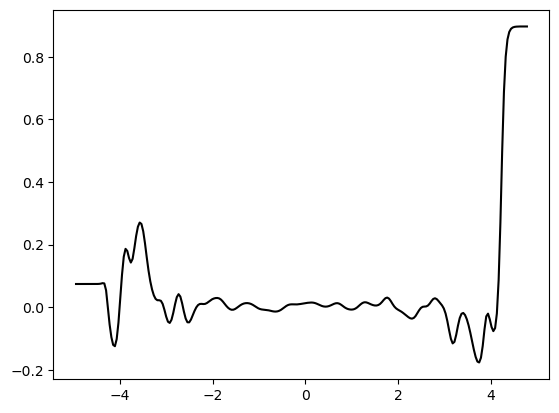

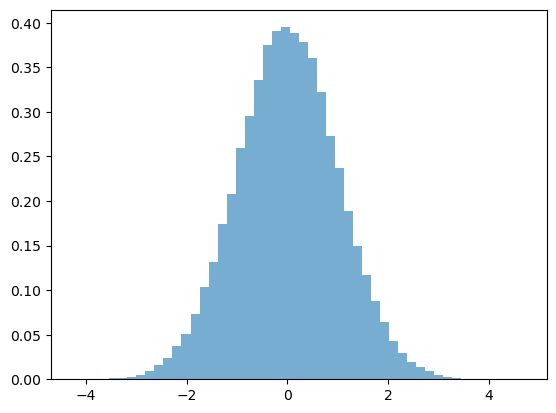

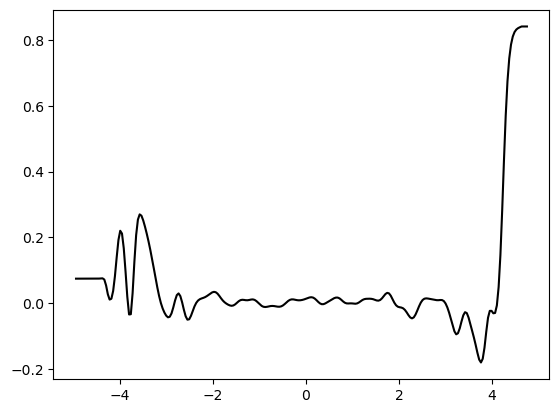

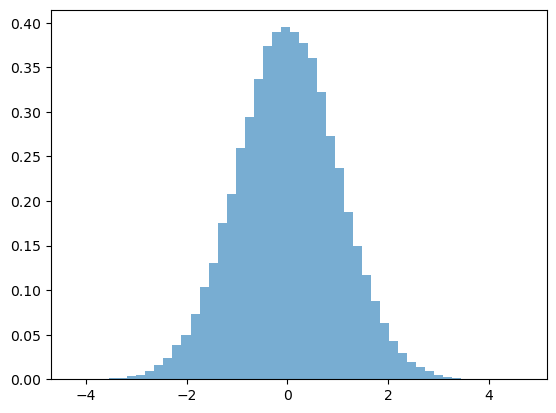

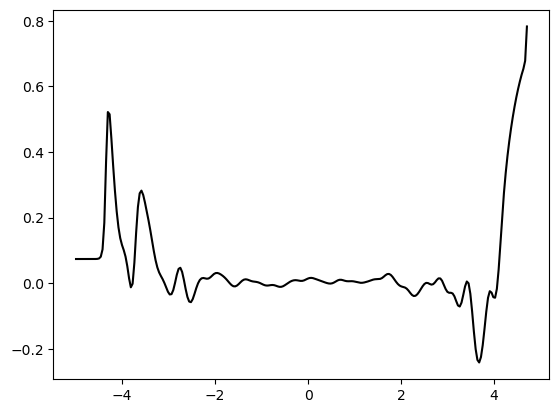

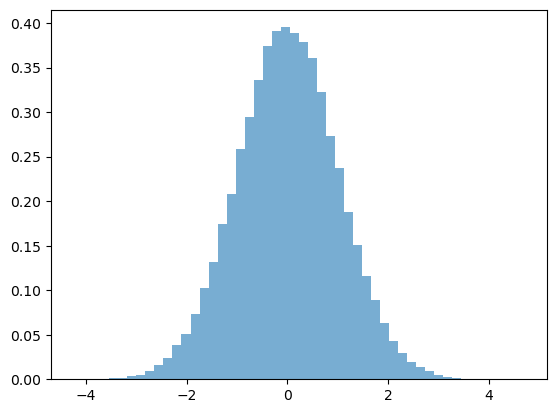

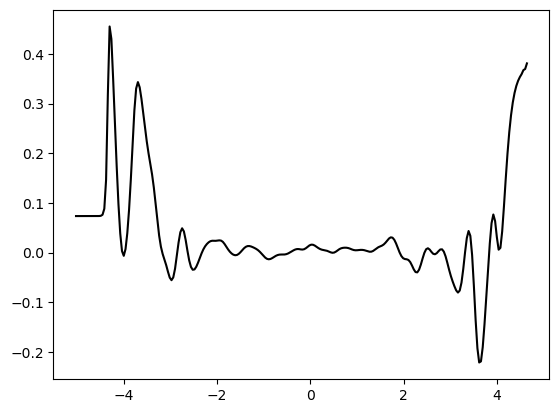

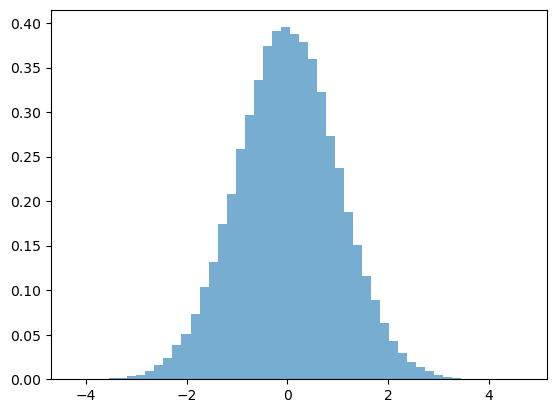

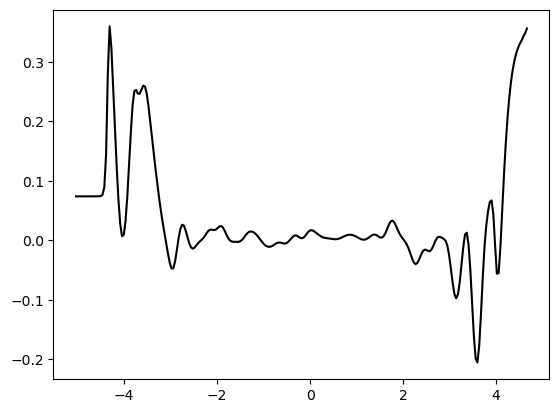

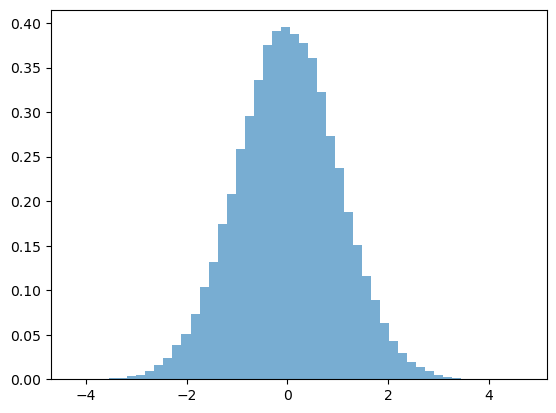

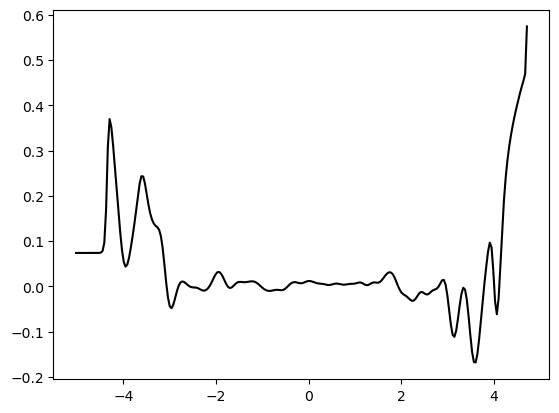

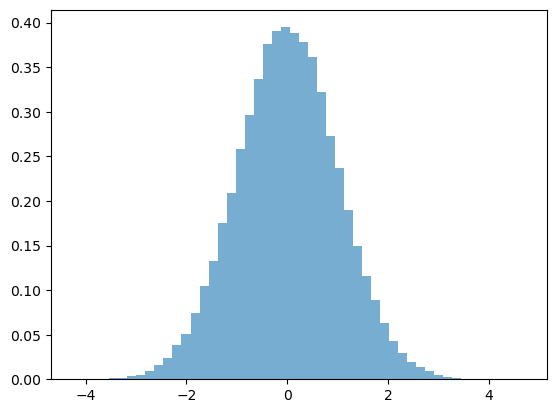

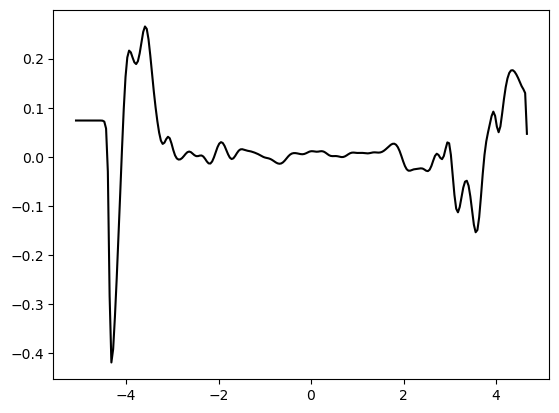

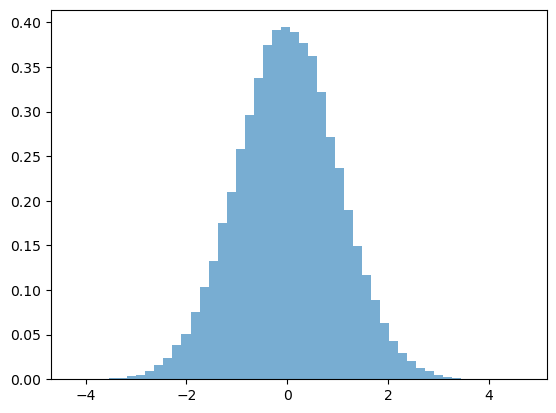

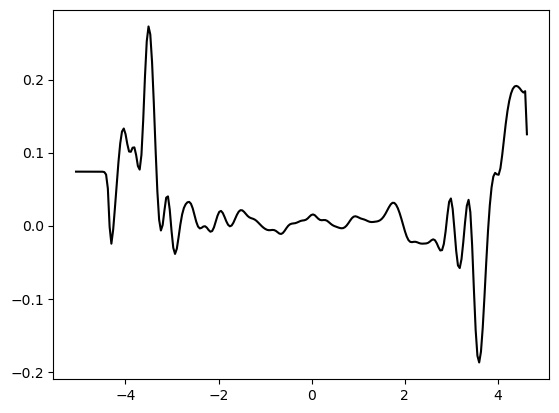

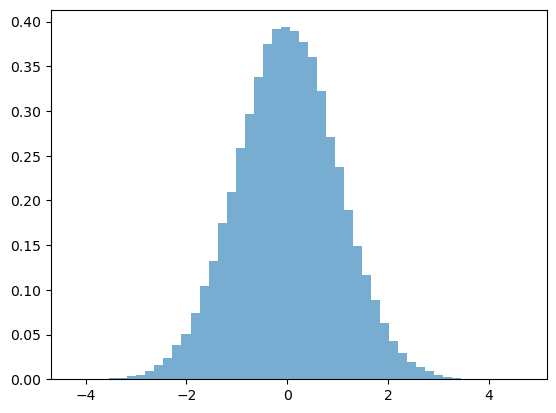

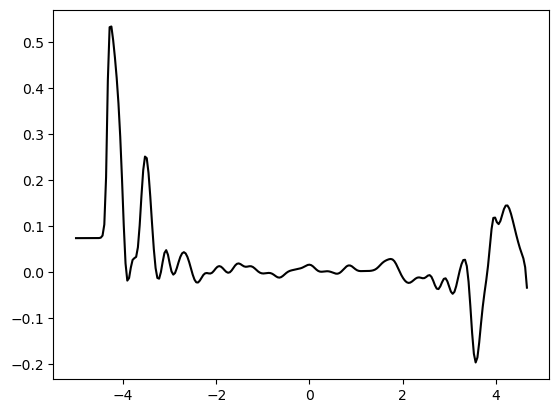

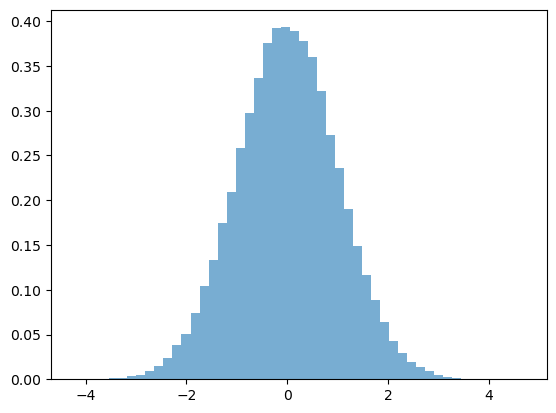

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from   scipy.stats import gaussian_kde, norm
from derivatives import grad,laplacian

# Parameters
num_particles = 10**5  # Number of Monte Carlo samples
num_steps = 100     # Time steps
dt = 0.001         # Time step size
T  = 1
τ  = 1

Y_min = -2
Y_max =  2

# Brownian increments
dW_t = np.sqrt(dt) * norm.rvs(loc=0, scale=1, size=(num_particles, num_steps, 2))  

# Container
θ = np.zeros((num_particles, num_steps))
Y = np.zeros((num_particles, num_steps))

# Initial conditions
θ[:,0] = np.random.normal(0, 1, num_particles)  # Initial condition (Normal distribution)

Y[:,0] = np.random.normal(0, 1, num_particles)  

# Half of the particles to +1 and the other to -1
#Y[:num_particles//2,0] = 1
#Y[num_particles//2:,0] =-1

# EY_cη, η = Y_map_KDE(θ[:,0], Y[:,0])  # Should technically specify bounds for Y and boundry conditions
# #EY_cη, η = Y_map(A=Y[:,0],B=θ[:,0],N=32)
# plt.plot(η, EY_cη, 'k')
# plt.show()


# #EY_cη, η = Y_map_KDE(θ[:,0], Y[:,0])  # Should technically specify bounds for Y and boundry conditions
# EY_cη, η = Y_map(A=Y[:,0],B=θ[:,0],N=32)
# plt.plot(η, EY_cη, 'k')
# plt.show()

# plt.hist(Y[:, 0], bins=50, density=True, alpha=0.6)
# #plt.xlim([-1.1, 1.1])
# plt.show()

# Euler Maruyama
for n in range(1, num_steps):

    # Calculate Y via joint pdf O(num_particles*2)
    EY_cη, η = Y_map_KDE(θ[:, n-1], Y[:, n-1])  # Should technically specify bounds for Y and boundry conditions
    dYdη  = grad(η)@EY_cη
    dY2dη2= laplacian(η)@EY_cη

    if n%(num_steps // 10) == 0:
        plt.plot(η, EY_cη, 'k')
        plt.show()
        plt.hist(Y[:, n-1], bins=50, density=True, alpha=0.6)
        #plt.xlim([-1.1, 1.1])
        plt.show()

    # then derivatives => still scales linearly
    dY  = np.interp(x=θ[:, n-1], xp=η ,fp=dYdη  )
    ddY = np.interp(x=θ[:, n-1], xp=η ,fp=dY2dη2)

    # Update particles
    θ[:, n] = θ[:, n-1] -  (      1/T) * (         θ[:, n-1]) * dt +    np.sqrt(2/T) * dW_t[:,n-1,0]
    Y[:, n] = Y[:, n-1] +  (1/τ + 1/T) * (ddY - dY*θ[:, n-1]) * dt + dY*np.sqrt(2/τ) * dW_t[:,n-1,1]

    # Apply Reflecting/bcs
    #Y[:, n] = np.where(Y[:, n] > Y_max, Y_max - (Y[:, n] - Y_max), Y[:, n]) # Reflect back inside
    #Y[:, n] = np.where(Y[:, n] < Y_min, Y_min + (Y_min - Y[:, n]), Y[:, n]) # Reflect back inside


# # Estimate the probability density function at final time step using KDE
# b_values = np.linspace(-1.2, 1.2, 100)
# kde = gaussian_kde(b[:, -1])
# pdf_values = kde(b_values)

# # Plot the Monte Carlo histogram and estimated density
# plt.figure(figsize=(8, 5))
# plt.hist(b[:, -1], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
# plt.plot(b_values, pdf_values, 'r-', label="Kernel Density Estimation (KDE)")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.title("Monte Carlo Solution of Fokker-Planck")
# plt.legend()
# plt.show()